In [1]:
import numpy as np
import healpy as hp
import csv
import sys
sys.path.insert(0,'/home/larry/project/')
import scipy
from scipy.interpolate import interp1d
from scipy import signal
import matplotlib.pyplot as plt
from scipy.interpolate import LinearNDInterpolator

In [2]:
#get info from the files here
#square wave window info, tstamp multiplier, and starting timestamp from bb filename
#row numbers (from altitude), tstamp offset from ulog files

def GetFileInfo(bbfile, ulogposfile, uloggpsfile, altitude):
    split = bbfile.split('_')
    sqwave_window = round(int(split[3])*int(split[4])*4096/(250*10**6))
    bb_tstamp_mult = int(split[3])
    bb_tstamp_start = int(split[2])
    
    delim = '|'
    file = ulogposfile
    csvfile = open(file, 'r')
    reader = csv.DictReader(csvfile, delimiter=delim)
    rownum = 0
    startflag = False
    endflag = False

    for row in reader:
        if rownum == 0:
            altref = float(row['z'])*-1.0
        rownum += 1
        alt = float(row['z'])*-1.0
#         if alt >= altitude/3.28 - 1.2-1.43 and startflag == False: #need to set 0 alt, this is for raster
        if alt-altref >= altitude/3.28-1.5 and startflag == False: 
            startrow = rownum
            startflag = True
#         if alt <= altitude/3.28 - 2-1.43 and startflag == True and endflag == False: #need to set 0 alt, this is for reaster
        if alt-altref <= altitude/3.28 - 1.5 and startflag == True and endflag == False:
            endrow = rownum
            endflag = True

    csvfile.close()

    file = uloggpsfile
    csvfile = open(file, 'r')
    reader = csv.DictReader(csvfile, delimiter=delim)

    row = next(reader)
    dgps_tstamp_offset = int((int(row['time_utc_usec']) - int(row['timestamp']))*10**-6)
    csvfile.close()

    return sqwave_window, bb_tstamp_mult, bb_tstamp_start, startrow, endrow, dgps_tstamp_offset

In [3]:
def LatLonToXY(lat,lon,ref_lat,radius):
    """
    Take a set of lat/lon points and convert to global XY (units are meters)
    """
    x = radius*np.radians(lon)*np.cos(np.radians(ref_lat))
    y = radius*np.radians(lat)
    return x, y

def to_spherical(x,y,z):
    # x and y are cartesian coordinates
    # z is relative altitude
    rhos = np.sqrt(x**2+y**2+z**2)
    thetas = np.arccos(z/rhos) # Zentih angle
    phis = np.arctan2(y,x) # Azimuthal angle
    return rhos,thetas,phis

def mollview(beam,title='Beam Map'):
    hp.mollview(beam,title=title,coord=['C'], rot=[0,90,270],flip='geo', norm='hist')
#     hp.mollview(beam,title=title,coord=['C'], rot=[0,90,270],flip='geo')
    hp.graticule(coord='C')
    for ra_label in range(0,360,30):
        hp.projtext(ra_label-0.01, 0, str(ra_label), lonlat=True, coord='C')
    hp.projtext(0, -30, '-30', lonlat=True, coord='C')
    hp.projtext(0, -60, '-60', lonlat=True, coord='C')
    hp.projtext(180, -30, '-30', lonlat=True, coord='C')
    hp.projtext(180, -60, '-60', lonlat=True, coord='C')

def InterpRecData(tstamp, rec_times, rec_data):
    """
    Interpolates the receiver intensity data at the input timestamp
    Assumes timestamps are monotonically increasing  
    See code further down, I think there's a smarter more compact way to do this with SciPy.
    """
    interp_data = False
    #get the index of the drone data that is closest in time to the receiver /
    #data (lower bounded tstamp)
    tstamp_i = rec_times[rec_times <= tstamp].argmax()
    if tstamp_i != len(rec_data)-1:
        #receiver data points to interpolate, the input tstamp is between these points
        rec_data1 = rec_data[tstamp_i]
        rec_data2 = rec_data[tstamp_i+1]
        
        #receiver timestamps corresponding to the above datapoints
        rec_time1 = rec_times[tstamp_i]
        rec_time2 = rec_times[tstamp_i+1]

        #points to interpolate    
        xi = [rec_time1, rec_time2] #x values
        rec_points = [rec_data1, rec_data2] #y values
    
        #interpolate for intensity
        interp_data = np.interp(tstamp, xi, rec_points)
    
    return interp_data

def ReadUlog(file, delim):
    """
    Read in data from a csv-converted ulog
    """
    csvfile = open(file, 'r')
    reader = csv.DictReader(csvfile, delimiter=delim)

    xcoord = []
    ycoord = []
    alt = []
    time=[]

    for row in reader:
        
        xcoord.append(float(row['y']))
        ycoord.append(float(row['x']))
        alt.append(float(row['z'])*-1.0)
        time.append(float(row['timestamp'])*10**-6)

    csvfile.close()
    
    return np.array(time, dtype=object), np.array(xcoord), np.array(ycoord), np.array(alt)

In [4]:
def FitSquareWave(rdata, rtstamps, sqwave_window, dutycycle = .25):

#this function uses IQ demod to fit a squarewave in 1-second chunks, then joins them all together and returns the fitted square wave

    window = sqwave_window
    datasplit = np.array_split(rdata, window)
    timesplit = np.array_split(rtstamps, window)
    timesplit = np.array(timesplit, dtype=object)

    for i in range(len(timesplit)):
        timesplit[i] = timesplit[i].astype(float)

    squares = np.zeros(len(timesplit), dtype=object)

    for i in range(len(squares)):
        squares[i] = np.zeros(len(timesplit[i]))
    squaresfit = squares.copy()

    for i in range(len(squares)):
        squares[i] = signal.square(2*np.pi*10*timesplit[i], duty = dutycycle)

    A1s = np.zeros(squares.shape[0])
    B1s = np.zeros(squares.shape[0])

    for i in range(len(squares)):
        A1s[i] = np.trapz(datasplit[i]*np.sin(2*np.pi*10*timesplit[i]),timesplit[i])
        B1s[i] = np.trapz(datasplit[i]*np.cos(2*np.pi*10*timesplit[i]),timesplit[i])

    A2s = np.zeros(squares.shape[0])
    B2s = np.zeros(squares.shape[0])

    for i in range(len(squares)):
        A2s[i] = np.trapz(squares[i]*np.sin(2*np.pi*10*timesplit[i]),timesplit[i])
        B2s[i] = np.trapz(squares[i]*np.cos(2*np.pi*10*timesplit[i]),timesplit[i])

    P1s = np.arctan2(B1s,A1s)
    P2s = np.arctan2(B2s,A2s)
    Phases = P2s-P1s

    for i in range(len(squares)):
        squaresfit[i] = signal.square(2*np.pi*10*timesplit[i]-Phases[i], duty = dutycycle)

    fitted = np.hstack(squaresfit)

    return fitted

In [5]:
def DemodData(rdata, rtstamps, sqwave_window):
    #fit the peaks (tops) and troughs (bottom) of the squarewave to the received chopped data. Dutycycle is different to exclude transitions in the chopping.
    topsquare = FitSquareWave(rdata, rtstamps, sqwave_window, dutycycle = 0.3)
    topsquare = topsquare*.5+.5
    bottomsquare = FitSquareWave(rdata, rtstamps, sqwave_window, dutycycle = 0.7)
    bottomsquare = bottomsquare*.5-.5

    #multiply the data by the fitted squarewave
    topdata = topsquare*rdata.data
    bottomdata = bottomsquare*rdata.data
    
    #combine peak and trough data and zip with timestamps, to keep track of things    
    dtot = topdata+bottomdata
    ziptot = zip(dtot, rtstamps)
    ziptot = list(ziptot)
    ziptot = np.array(ziptot)

    
    #masked array of the data
    dmaskarr = np.ma.masked_where(ziptot==0, ziptot)
    dmaskarr.mask[:,1] = dmaskarr.mask[:,0]
    
    #now get indices where sign changes (peak vs trough in the chopped data)
    inds=[]
    sign = 0
    for i in range(len(dmaskarr)):
#         if dmaskarr[i].any():
        newsign = np.sign(dmaskarr[i][0])
        if not newsign:
            newsign = 0
        if newsign != sign:
            sign = newsign
            inds.append(i)
    
                
    #average the peaks and troughs            
    avglist=[]
    for i in range(len(inds)):
        if i != len(inds)-1:
            mean = np.mean(dmaskarr[inds[i]:inds[i+1]],0)
            if mean.any():
                avglist.append(mean)
#             avglist.append(np.mean(dmaskarr[inds[i]:inds[i+1]],0))
        else:
            mean = np.mean(dmaskarr[inds[i]:],0)
            if mean.any():
                avglist.append(mean)
            
#             avglist.append(np.mean(dmaskarr[inds[i]:],0))
    
#     return avglist


#     for each peak, average the trough on either side and subtract (really add because these values are negative)
    plotdata = []
    checklow = []
    checkhigh = []
    for i in range(len(avglist)):
#         if avglist[i][0] > 0 and avglist[i-1].any() and avglist[i+1].any():
        if i == 0:
            continue
        try:
            if avglist[i][0]>0:
                if avglist[i+1][0] < 0 and avglist[i-1][0] >0:
                    corr_data = avglist[i][0] + avglist[i+1][0]/2
                    corr_time = (avglist[i][1] + avglist[i+1][1])/2
                elif avglist[i-1][0] < 0 and avglist[i+1][0] >0:
                    corr_data = avglist[i][0] + avglist[i-1][0]/2
                    corr_time = (avglist[i][1] + avglist[i-1][1])/2
                elif avglist[i-1][0] <0 and avglist[i+1][0] <0:
                    corr_data = avglist[i][0]+(avglist[i-1][0]+avglist[i+1][0])/2.0
                    corr_time = (avglist[i][1]+avglist[i-1][1]+avglist[i+1][1])/3
                else:
                    corr_data = avglist[i][0]
                    corr_time = avglist[i][1]
#                 corr_data = avglist[i][0]+(avglist[i-1][0]+avglist[i+1][0])/2.0
#                 corr_time = (avglist[i][1]+avglist[i-1][1]+avglist[i+1][1])/3
                    
#                    corr_data = avglist[i][0]+(avglist[i-1][0]+avglist[i+1][0])/2.0
#                 corr_data = avglist[i][0]-15.0
#                 corr_data = avglist[i][0]
                checklow.append((avglist[i-1][0], avglist[i+1][0]))
                checkhigh.append(avglist[i][0])
#                 corr_time = (avglist[i][1]+avglist[i-1][1]+avglist[i+1][1])/3
#                 plotdata.append((corr_data, avglist[i][1]))
                plotdata.append((corr_data, corr_time))
        except IndexError:
            continue
            
    plotdata = np.array(plotdata)
    
    
#     i = 0
#     avglist = np.array(avglist)
#     plotdata = []
#     while i+20 < len(avglist):
#         corrdata = np.average(avglist[np.array(np.where(avglist[i:i+20,0]>0))+i,0])+np.average(avglist[np.array(np.where(avglist[i:i+20,0]<0))+i,0])
# #         corrdata = np.average(avglist[np.array(np.where(avglist[i:i+20,0]>0))+i,0])
#         tstamp = np.average(avglist[i:i+20,1])
#         plotdata.append((corrdata, tstamp))
#         i = i+20
           
#     plotdata = np.array(plotdata)

#     plotdata is an array of (corrected data, timestamp) values.

   
    return plotdata, dmaskarr, topsquare, bottomsquare, avglist, inds

In [6]:
def get_ant_xy(ptstamps, x, y, uloggpsfile, delim, ant_coord):
    
    def find_nearest(array, value):
        idx = (np.abs(array - value)).argmin()
        return idx

    csvfile = open(uloggpsfile, 'r')
    reader = csv.DictReader(csvfile, delimiter=delim)
    
    lat = []
    lon = []
    gtime = []
    
    for row in reader:
        
        lat.append(float(row['lat'])*10**-7)
        lon.append(float(row['lon'])*10**-7)
        gtime.append(float(row['timestamp'])*10**-6)
        
    lat = np.array(lat)
    lon = np.array(lon)
    gtime = np.array(gtime, dtype='object')
    
    bigarr = []
    for i in range(len(gtime)):
        idx = find_nearest(ptstamps, gtime[i])
        bigarr.append([gtime[i], lat[i], lon[i], x[idx], y[idx]])
    
    bigarr = np.array(bigarr)
    interp = LinearNDInterpolator(list(zip(bigarr[:,1], bigarr[:,2])), list(zip(bigarr[:,3], bigarr[:,4])))
    
    xcent, ycent=interp(ant_coord)
    
    return xcent, ycent

In [7]:
#set the inputs here
#averaged bb file, ulog pos file, ulog gps file, altitude


bbfile = "./MARS2023/drone/pols_4bit_1690301740_500_159912_0_None.npz" #A2 wide raster W

ulogposfile = "./MARS2023/drone/16_16_47_vehicle_local_position_0.csv" #A2 wide raster W
uloggpsfile = "./MARS2023/drone/16_16_47_vehicle_gps_position_0.csv" #A2 wide raster W

altitude = 200 #feet AGL

# ant_coord = (79.4171862, -90.7672382) #A1 (middle MARS station)
# ant_coord = (51.4646887, -68.2352842) #Uapishka N antenna
ant_coord = (79.4172218, -90.7588146) #A2 (shed MARS station)
# ant_coord = (79.4154227, -90.7730812) #A3 (newest MARS station)

In [8]:
sqwave_window, bb_tstamp_mult, bb_tstamp_start, startrow, endrow, dgps_tstamp_offset = GetFileInfo(bbfile, ulogposfile, uloggpsfile, altitude)

In [9]:
#read in ulog info
delim='|'

ptstamps, px, py, pz = ReadUlog(ulogposfile, delim)
dtstamps = ptstamps + dgps_tstamp_offset #correct for startup time - HARDCODED. find startup time in vehicle_gps_position. Subtract column 1 from 2.
dtstamps = dtstamps[startrow:endrow] #chunk of file used - HARDCODED. needs to fall within tstamps of receiver.
x = px[startrow:endrow]  #230:9900 are rows of the vehicle_local_pos file where the tstamps match the npz file. in this case, drone in flight.
y = py[startrow:endrow]
z = pz[startrow:endrow]

In [11]:
xcent, ycent = get_ant_xy(ptstamps, px, py, uloggpsfile, delim, ant_coord)

In [13]:
#read in averaged baseband info from npz file
with np.load(bbfile) as npz:
    pol11 = np.ma.MaskedArray(npz['datap00'],npz['maskp00']) 

rdata = pol11[:,1].data
rtstamps = np.arange(0,len(rdata),1, dtype=object)
rtstamps = rtstamps*bb_tstamp_mult*4096/(250*10**6)
rtstamps = rtstamps+bb_tstamp_start #offset by start time of data, used in autocorravg - HARDCODED

In [17]:
#demod the data
plotdata, dmaskarr, topsquare, bottomsquare, avglist, inds = DemodData(rdata, rtstamps, sqwave_window)

/home/larry/anaconda3/lib/python3.9/site-packages/scipy/signal/_waveforms.py:150: RuntimeWarning: invalid value encountered in remainder
  tmod = mod(t, 2 * pi)


In [18]:
paper_tstamps = (rtstamps - rtstamps[0]) / 60.0
paper_pow = rdata/np.nanmax(rdata)

Text(0, 0.5, 'normalized received power')

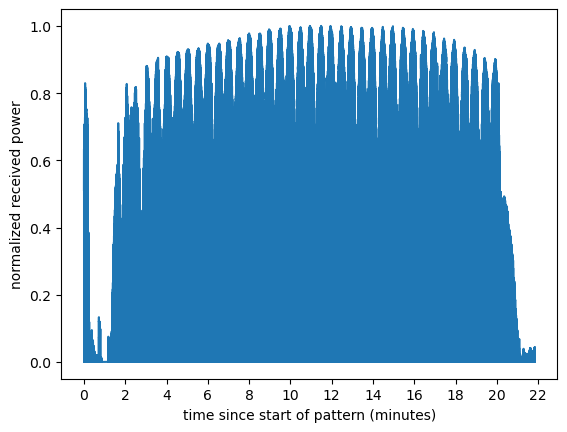

In [19]:
plt.plot(paper_tstamps, paper_pow)
plt.xticks(np.arange(min(paper_tstamps), max(paper_tstamps)+1, 2.0))
plt.xlabel("time since start of pattern (minutes)")
plt.ylabel("normalized received power")

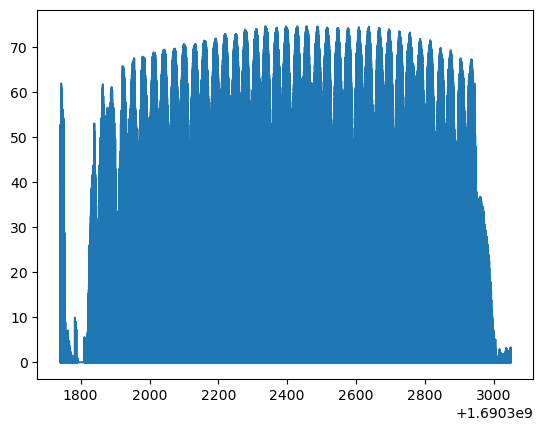

In [20]:
# plt.plot(rtstamps[57883:58083], rdata[57883:58083])
plt.plot(rtstamps, rdata)


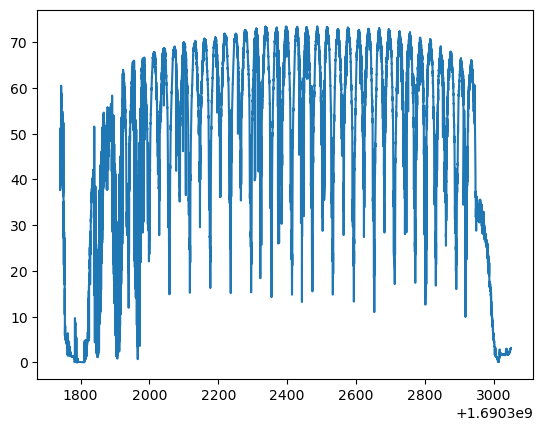

In [21]:
plt.plot(plotdata[:,1], plotdata[:,0])

In [22]:
paper_dtstamps = (plotdata[:,1] - plotdata[:,1][0])/60.0
paper_power = plotdata[:,0]/np.nanmax(plotdata[:,0])

([<matplotlib.axis.XTick at 0x7f595e987850>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

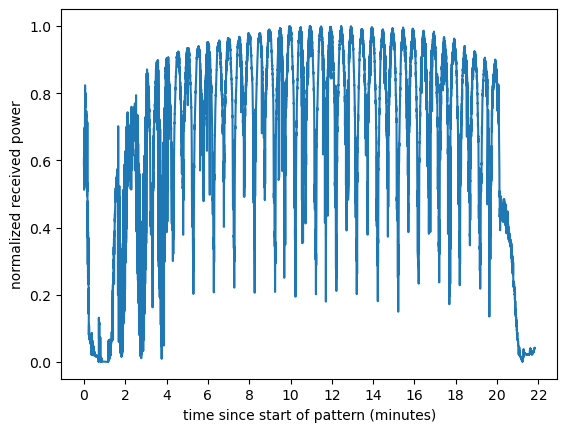

In [23]:
plt.plot(paper_dtstamps, paper_power)
plt.xlabel("time since start of pattern (minutes)")
plt.ylabel("normalized received power")
plt.xticks(np.arange(min(paper_dtstamps), max(paper_dtstamps)+1, 2.0))

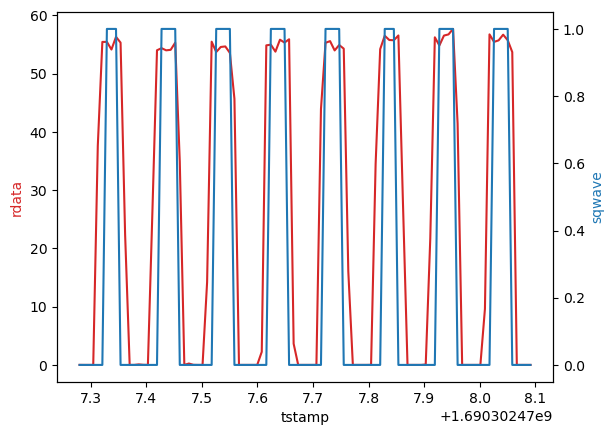

In [25]:
#checking square wave fitting

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('tstamp')
ax1.set_ylabel('rdata', color=color)
ax1.plot(rtstamps[90000:90100], rdata[90000:90100], color=color)
# ax1.xaxis.set_major_locator(md.MinuteLocator(interval=90))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
# ax2.set_ylabel('efoy status', color=color)  # we already handled the x-label with ax1
# ax2.plot(times, efoystatus, color=color)
ax2.set_ylabel('sqwave', color=color)  # we already handled the x-label with ax1
ax2.plot(rtstamps[90000:90100], topsquare[90000:90100], color=color)

In [26]:
#receiver data and tstamps from demodded data
rdata = plotdata[:,0]
rtstamps = plotdata[:,1]


In [27]:
print(np.mean(rdata))
print(np.std(rdata))

49.53561839292237
21.309565910412886


In [28]:
# probably a smarter way to do the interpolation using scipy
interp = scipy.interpolate.interp1d(rtstamps, rdata)
i = interp(list(dtstamps))
i = np.array(i)

In [29]:
#center on antenna coords
# x = x-np.median(x)
# y = y-np.median(y)
x = x - xcent
y = y - ycent
rs,thetas,phis = to_spherical(x,y,z)

In [152]:
#correct for distance - may not be necessary
#kit this is not used right now.
# r0 = 10
# i = i + 20*np.log10(rs/r0)
# i = i*((altitude/3.28)/rs)**2
i = i*(rs/np.min(rs))**2
# i = (rs/np.min(rs))**2

In [31]:
#healpix stuff
nsides = 32
nPixels = hp.nside2npix(nsides)
hpx_beam = np.zeros(nPixels)

# Find pixel # for a given theta and phi
pixInd = hp.ang2pix(nsides,thetas,phis,nest=False)
# pixInd = hp.vec2pix(nsides, x, y, z, nest=False)

In [60]:
# # averages pixel values for better beam representation. 

# pixdict = {k: [0,0] for k in pixInd}

# for j in range(len(pixInd)):
#     pixdict[pixInd[j]][0] += i[j]
#     pixdict[pixInd[j]][1] += 1
    
# inds = np.asarray(list(pixdict.keys()))
# vals = list(pixdict.values())
# intens = [j[0]/j[1] for j in vals]

# # Set pixel values at pixInd to power values
# hpx_beam[inds] = intens

# # Grey out pixels with no measurements
# hpx_beam[hpx_beam == 0] = np.nan
# # hpx_beam[hpx_beam < 97.8] = np.nan
# #hpx_beam[hpx_beam < 5] = np.nan

In [32]:
#new way of doing this to get count and stddev values
# averages pixel values for better beam representation. 

pixdict = {k: [[],0] for k in pixInd}

for j in range(len(pixInd)):
    pixdict[pixInd[j]][0].append(i[j])
    pixdict[pixInd[j]][1] += 1
    
inds = np.asarray(list(pixdict.keys()))
vals = list(pixdict.values())
intens = [sum(j[0])/j[1] for j in vals]

# Set pixel values at pixInd to power values
hpx_beam[inds] = intens

# Grey out pixels with no measurements
hpx_beam[hpx_beam == 0] = np.nan

In [63]:
#to visualize how many drone timestamps are in each pixel
counts = [j[1] for j in vals]
# for j in range(len(counts)):
#     if counts[j]>40:
#         counts[j]=np.nan

# Set pixel values to counts
hpx_beam[inds] = counts

# Grey out pixels with no measurements
hpx_beam[hpx_beam == 0] = np.nan


In [66]:
#to visualize stddev of each pixel
stddev = [np.std(j[0]) for j in vals]

# Set pixel values to stddev
hpx_beam[inds] = stddev

# Grey out pixels with no measurements
hpx_beam[hpx_beam == 0] = np.nan


In [68]:
#convert stdev to snr
snr = 10*np.log10(np.asarray(intens)/np.asarray(stddev))
hpx_beam[inds] = snr

0.0 180.0 -180.0 180.0


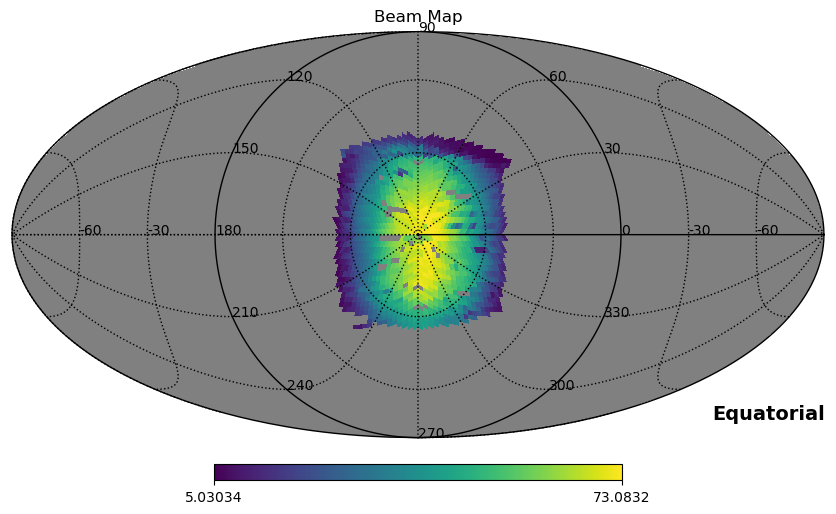

In [33]:
mollview(hpx_beam)

In [34]:
hpx_beam = hpx_beam/np.nanmax(hpx_beam)

In [35]:
hpx_beam_paper = [np.float64(np.format_float_positional(x, precision=2, unique=False, fractional=False, trim='k')) for x in hpx_beam]

In [36]:
hpx_beam_paper = np.around(hpx_beam, decimals=3)

In [38]:
def orthview(beam,title='Beam Map'):
    hp.orthview(beam, title=title, coord=['C'], rot=[0,90,270], half_sky=True, flip='geo', norm='hist', notext=True, unit = 'normalized received power')
#     hp.mollview(beam,title=title,coord=['C'], rot=[0,90,270],flip='geo')
    hp.graticule(coord='C', dmer=30)
    for ra_label in range(0,120,30):
        hp.projtext(ra_label, 25, str(ra_label), lonlat=True, coord='C')
    for ra_label in range(120,240,30):
        hp.projtext(ra_label, 15, str(ra_label), lonlat=True, coord='C')
    for ra_label in range(240,300,30):
        hp.projtext(ra_label, 10, str(ra_label), lonlat=True, coord='C')
    hp.projtext(300, 20, '300', lonlat=True, coord='C')
    hp.projtext(330, 26, '330', lonlat=True, coord='C')
    hp.projtext(270, 30, '30', lonlat=True, coord='C')
    hp.projtext(270, 60, '60', lonlat=True, coord='C')

0.0 180.0 -180.0 180.0


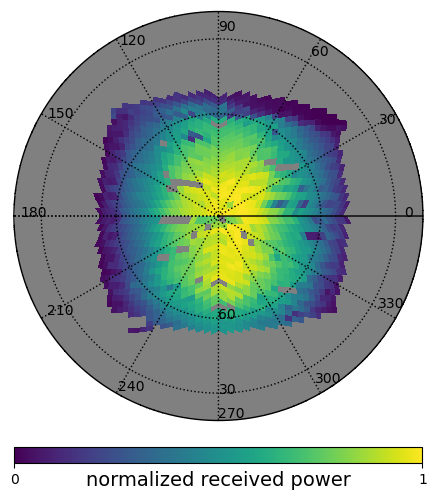

In [46]:
orthview(hpx_beam_paper, '')

In [79]:
import matplotlib.pyplot as plt

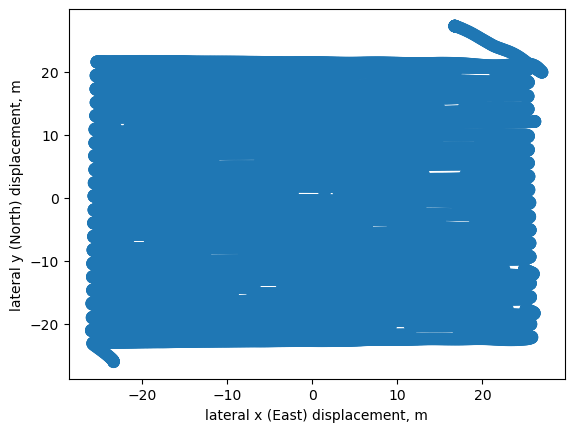

In [80]:
plt.scatter(x,y,z)
plt.xlabel('lateral x (East) displacement, m')
plt.ylabel('lateral y (North) displacement, m')
plt.show()